# Linear Regression

* Classical linear regression with fixed slopes and intercept.

# Optimisation Methods

## Analytical Solution
    * When there is a closed from solution to the problem.

## Sampling

* MCMC: Gather samples from the posterior P(theta|x,y) and then make conclusions about theta.
    * <strong>Gibbs sampling</strong> (we can run an example of) (needs to be derived)
    * <strong>Metropolice Hastings</strong> (rejection sampling).
    * <strong>Hamiltonian MC</strong> (Inverse the porbability functional and give the sampling a kick every once in a while).
    * <strong>NUTS</strong>.

## Variational Inference

* Variational Inference (EM being a special case thereof and the HARD EM is an even more special case). This is supposed to be faster than MCMC but only single point estimates for the parameters (unless parameters are treated like random variables), not samples.
    * Apporximate the posterior P(theta|x,y) with a simpler, factorised distribution which will miss the correlation properties of the posterior. But you will still get insite about each variable (like MAP).
    * All this is really well explained in https://chrischoy.github.io/research/Expectation-Maximization-and-Variational-Inference/ and http://www.cs.uoi.gr/~arly/papers/SPM08.pdf

# MCMC
    * Gibbs sampling: When it is difficult to sample from P(theta|x,y).
    * Then sample from P(theta1|x,y,theta2-n) and then P(theta2|x,y,theta1 and thata3-n) etc

## Random Sampling with MCMC
### With Numpy 

<img src="../img/multivariate-normal.png" width="550px" />

In [49]:
import numpy as np
import matplotlib.pyplot as plt

In [50]:
np_samples = np.random.multivariate_normal([0, 0], [[1, 0.8], [0.8, 1]], 1000)

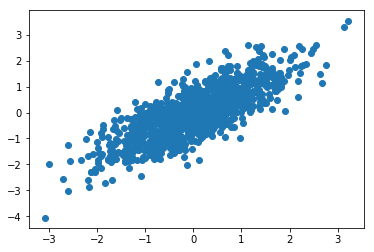

In [51]:
plt.scatter(np_samples.T[0], np_samples.T[1])
plt.show()

### Gibbs Sampling

I can be shown/proven that the equlibrium distribution of the markov chain is the desired distribution.

\begin{align*}
& p(x) \sim N(0,1) \\
& while (true) \{ \\
&       & p(y) \sim N(x*\rho,\sqrt{1-\rho^2}) \\
&       & p(x) \sim N(y*\rho,\sqrt{1-\rho^2}) \\
& \}
\end{align*}

In [52]:
def gibbs_bi_gaussian(iter=2000, rho=1, skip=0):
    samples = []
    x = 0
    y = 0
    for i in range(iter):
        std = np.sqrt(1 - rho ** 2)
        x = np.random.normal(loc=y * rho, scale=std)
        y = np.random.normal(loc=x * rho, scale=std)
        samples.append([x, y])
    if skip > 1:
        samples = samples[::int(skip)]
    return np.array(samples)

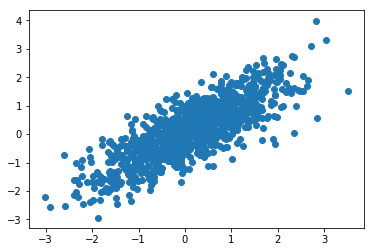

In [53]:
gibbs_samples = gibbs_bi_gaussian(iter=2000, rho=0.8, skip=2)
plt.scatter(gibbs_samples.T[0], gibbs_samples.T[1])
plt.show()

# Generate Data

In [54]:
alpha = 5.5 # Slope
beta  = 3   # Intercept
std   = 1   # STD of error

In [55]:
x = np.random.normal(loc=0, scale=1, size=1000)

In [56]:
y = x * alpha + beta + np.random.normal(loc=0, scale=std, size=1000)

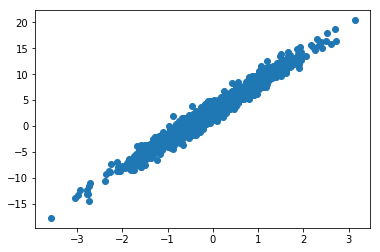

In [57]:
plt.scatter(x=x, y=y)
plt.show()

# Model

<img src="../img/linear_regression.png" />

In [69]:
import pystan as ps

In [65]:
linear_regression_model = """
data {
    int N;     # number of data points
    real x[N]; # Input data (predictor)
    real y[N]; # Output data (predicted)
}
parameters {
    real a;    # Slope
    real b;    # Intercept
    real s;    # STD of error
}
model {
    real mu[N];

    b ~ normal(0, 20);   # Prior for intercept
    a ~ normal(0, 20);   # Prior for slope
    s ~ inv_gamma(5, 3); # Prior for error
    
    for (i in 1:N) {     # Linear Relationship between x and y
        mu[i] <- x[i] * a + b;
        y[i] ~ normal(mu[i], s);
    }
}
"""

In [66]:
%%time

# Compile the model
model = ps.StanModel(model_code=linear_regression_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9970a48b4b83c299874af1d2c4f67cbd NOW.


CPU times: user 1.01 s, sys: 42.9 ms, total: 1.05 s
Wall time: 1min 5s


In [67]:
%%time

# Run with data
sam = model.sampling(data={
    'N': len(x),
    'x': x,
    'y': y
})

/home/nawarhalabi/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


CPU times: user 19.4 ms, sys: 28.7 ms, total: 48 ms
Wall time: 3.58 s


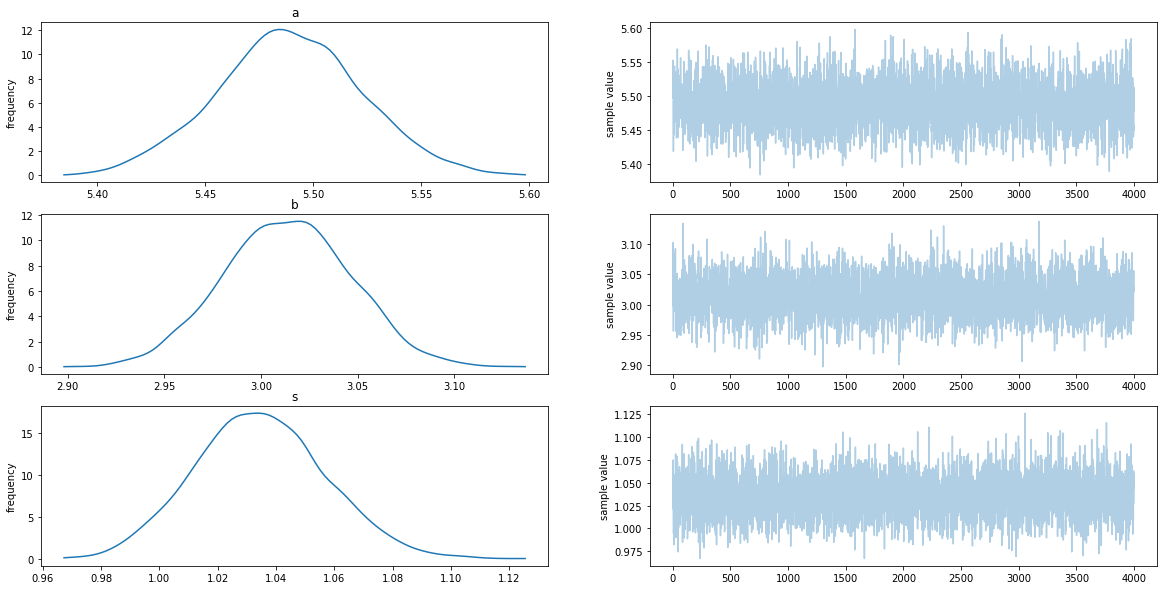

In [68]:
# Plot
ax = sam.plot()
ax.set_size_inches(20, 10)

# Variational Bayes (VB)

In [63]:
%%time

# Variational Bayes
fit = model.vb(data={
    'N': len(x),
    'x': x,
    'y': y
}, iter=2000)

/home/nawarhalabi/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


CPU times: user 154 ms, sys: 4.11 ms, total: 159 ms
Wall time: 157 ms


In [64]:
# Converged results
import pandas as pd
pd.DataFrame({
    'param': fit['sampler_param_names'],
    'mean': fit['mean_pars']
})

,param,mean
0,a,5.506293
1,b,3.182920
2,s,0.956839
